### Data loading and pre-processing

In [276]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, f1_score, homogeneity_score, accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import GridSearchCV
import time
from sklearn.mixture import GaussianMixture 
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import t as student
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


In [213]:
file = r"..\data\dataset.csv"

def load_phishing_data(filename):
    """
    Loads the Phishing website dataset 
    :param filename: path to csv file
    :return: X (data) and y (labels)
    """

    data = pd.read_csv(filename,delimiter=",")
    # y includes our labels and x includes our features
    y = data.Result # win  lose or draw
    # "Result" as it is the label
    to_drop = ['Result']

    
    dataset_values = data.drop(to_drop, axis=1)
    X=dataset_values.values
    y = y.values
    

    y = y.astype(int)
    return X, y, dataset_values
X,y, dataset_values = load_phishing_data(file)
print(X[0:3])



[[ 1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1 -1  0  1  1  1  1
  -1 -1 -1 -1  1  1 -1]
 [ 2  1  1  1  1  1 -1  0  1 -1  1  1 -1  1  0 -1 -1  1  1  0  1  1  1  1
  -1 -1  0 -1  1  1  1]
 [ 3  1  0  1  1  1 -1 -1 -1 -1  1  1 -1  1  0 -1 -1 -1 -1  0  1  1  1  1
   1 -1  1 -1  1  0 -1]]


In [214]:
# Read data

print('Total number of examples in the dataset: %d' % X.shape[0])
print('Fraction of positive examples: %.2f%%' % (y[y == 1].shape[0]/y.shape[0]*100.0))

# Standardize data
X = preprocessing.scale(X)

# Split into training and test data. Use random_state to get the same results in every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=18)

# Data structures for storing best accuracies, training time and test time
num_classifiers = 5
best_accuracy = np.zeros(num_classifiers)
train_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)

Total number of examples in the dataset: 11055
Fraction of positive examples: 55.69%


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


### Clustering

In [218]:
classes=[-1,1]

def vote_cluster_class(classes, labels, y, K): #y is the labelled output set, labels is the index of 
                                               #cluster associated for each x
    count=[np.zeros(len(classes)) for i in range(K)] #k is the number of clusters
    for i in range(len(labels)):
        k=labels[i]
        for j in range(len(count[k])):
            if classes[j]==y[i]:
                count[k][j]+=1
                break
                
    #pred is the predicted class of hte cluster
    pred=[]          
    for k in range(len(count)): #for each cluster
        
        max=count[k][0]
        index=0
        
        for i in range(len(count[k])):#for each possible class
            if max<count[k][i]:
                max=count[k][i]
                index=i
        pred.append(classes[index])
    y_vote_cluster=[]    
    for i in range(len(y)):
        y_vote_cluster.append(pred[labels[i]])
        
    return pred, y_vote_cluster     #y_vote_cluster = label estimated after clustering, #pred = label of eac cluster

### K-Means

In [354]:
def k_means(X,y):

    kclusters = list(np.arange(2,30,2))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []
    labels = []
    for k in kclusters:
        t0 = time.time()
        kmeans = KMeans(n_clusters=k, n_init=10,random_state=100,n_jobs=-1).fit(X)
        t1 = time.time()
        train_times.append(t1-t0)
        sil_scores.append(silhouette_score(X, kmeans.labels_))
        pred, y_vote_cluster = vote_cluster_class([-1,1], kmeans.labels_, y, k)
        f1_scores.append(f1_score(y, y_vote_cluster))
        homo_scores.append(homogeneity_score(y, kmeans.labels_))
        labels.append(kmeans.labels_)

    return kclusters, sil_scores, f1_scores, homo_scores, train_times, pred

In [399]:
kclusters, sil_scores, f1_scores, homo_scores, train_times, cluster_label = k_means(X,y)

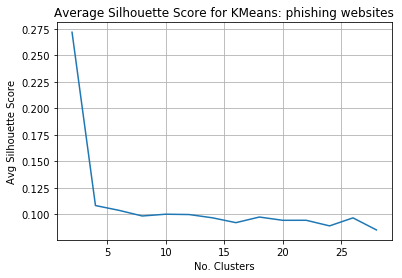

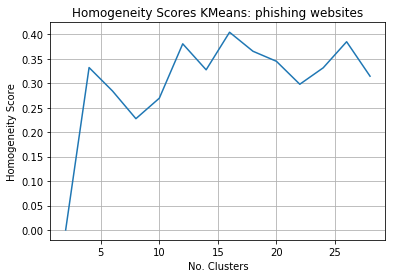

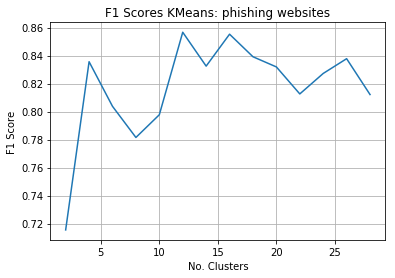

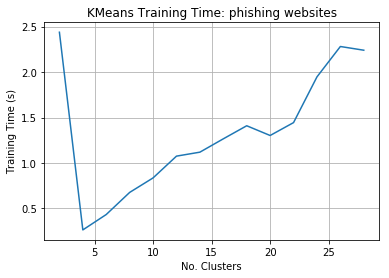

In [401]:
def plot_curve_k_means(kclusters, sil_scores, f1_scores, homo_scores, train_times, Title):
    # elbow curve for silhouette score
    dataset = 'phishing websites'

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Average Silhouette Score for KMeans'+Title+': ' + dataset)
    plt.show()

    # plot homogeneity scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Homogeneity Score')
    plt.title('Homogeneity Scores KMeans'+Title+': '+dataset)
    plt.show()


    # plot f1 scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, f1_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores KMeans'+Title+': '+dataset)
    plt.show()

    # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, train_times)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Training Time (s)')
    plt.title('KMeans Training Time'+Title+': ' +dataset)
    plt.show()
plot_curve_k_means(kclusters, sil_scores, f1_scores, homo_scores, train_times, '')

#### Best k : 12 or 16

### Gaussian Mixture Model (EM)

Let fit the number of gaussian k

In [395]:
def EM(X,y):

    kdist = list(np.arange(2,200,5))
    sil_scores = []; f1_scores = []; homo_scores = []; training_times = []; aic_scores = []; bic_scores = []
    
    for n in kdist:
        t0 = time.time()        
        em = GaussianMixture(n_components=n,covariance_type='full',n_init=1,warm_start=True,random_state=100).fit(X)
        t1 = time.time()
        training_times.append(t1-t0)        
        labels = em.predict(X)
        sil_scores.append(silhouette_score(X, labels))
        pred, y_vote_cluster = vote_cluster_class([-1,1], labels, y, n)
        f1_scores.append(f1_score(y, y_vote_cluster))
        homo_scores.append(homogeneity_score(y, labels))
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
    return sil_scores,f1_scores, homo_scores, train_times, aic_scores, bic_scores, pred

In [415]:
sil_scores,f1_scores, homo_scores, train_times, aic_scores, bic_scores, cluster_labels_em= EM(X,y)

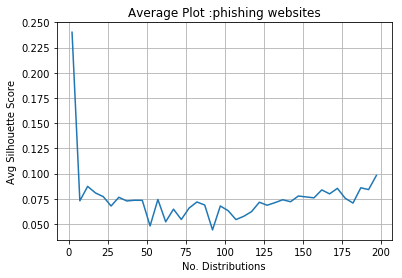

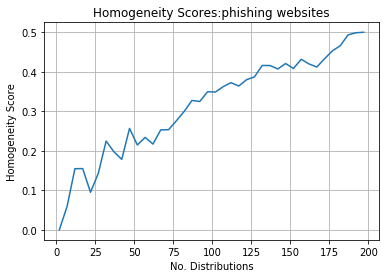

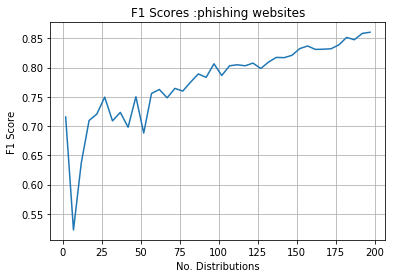

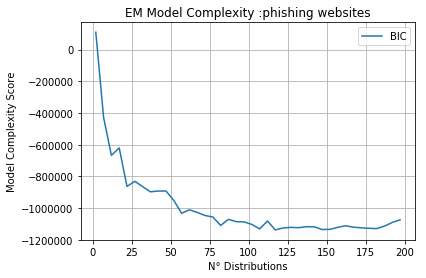

In [418]:
def plot_curves_EM(sil_scores,f1_scores, homo_scores, train_times, aic_scores, bic_scores,Title ):
    kdist = list(np.arange(2,200,5))
    # elbow curve for silhouette score
    fig = plt.figure()
    plt.plot(kdist, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Average Plot '+Title+':' +dataset)
    plt.show()

    # plot homogeneity scores
    fig = plt.figure()
    plt.plot(kdist, homo_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Homogeneity Score')
    plt.title('Homogeneity Scores'+Title+':' +dataset)
    plt.show()

    # plot f1 scores
    fig = plt.figure()
    plt.plot(kdist, f1_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('F1 Score')
    plt.title('F1 Scores '+Title+':' +dataset)
    plt.show()

    # plot model AIC and BIC
    fig = plt.figure()
    #plt.plot(kdist, aic_scores, label='AIC')
    plt.plot(kdist, bic_scores,label='BIC')
    plt.grid(True)
    plt.xlabel('N° Distributions')
    plt.ylabel('Model Complexity Score')
    plt.title('EM Model Complexity '+Title+':' +dataset)
    plt.legend(loc="best")
    plt.show()
    
    # plot model training time
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, train_times)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Training Time (s)')
    plt.title('EM Training Time'+Title+': ' +dataset)
    plt.show()
    
    
plot_curves_EM(sil_scores,f1_scores, homo_scores, train_times, aic_scores, bic_scores,'')


# Part 2 dimensionality reduction

### PCA

In [429]:
# Make an instance of the Model
def principalcomponentanalysis(X,y):
    Xpca=X.copy()
    y1=y.copy()
    #pca=PCA(0.95)
    pca = PCA() #sk-learn will choose the minimum number of principal component such that 95% of the variance is retained
    pca.fit(Xpca)
    Xpca=pca.transform(Xpca)
    explained_variance_ratio= pca.explained_variance_ratio_
    #components = pca.components_
    nb_components = explained_variance_ratio.size
    cumulative_variance = np.cumsum(explained_variance_ratio)
    eigenvalues = pca.singular_values_
    X_projected = pca.inverse_transform(Xpca)
    loss = ((X - X_projected) ** 2).mean()
    
    return (cumulative_variance, nb_components,explained_variance_ratio, eigenvalues, loss )



In [430]:
cumulative_variance, nb_components,explained_variance_ratio, eigenvalues, loss  = principalcomponentanalysis(X,y)

Text(0.5, 1.0, 'Variance:phishing websites')

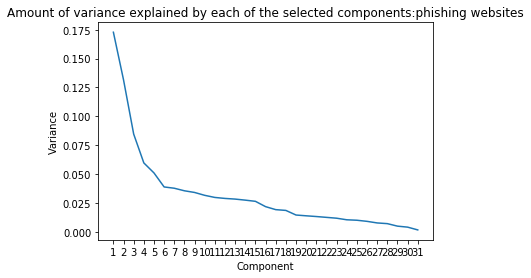

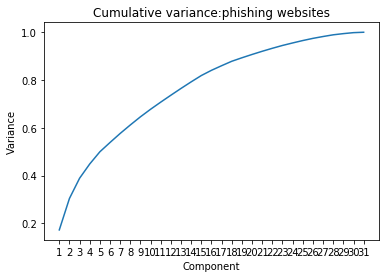

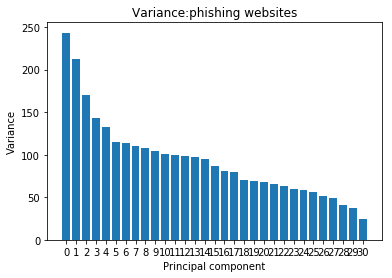

In [414]:
plt.figure()
plt.plot(np.arange(1, nb_components+1), explained_variance_ratio)
plt.xticks(np.arange(1, nb_components + 1))
plt.xlabel('Component')
plt.ylabel('Variance')
plt.title('Amount of variance explained by each of the selected components:' + dataset)


plt.figure()
plt.plot(np.arange(1, nb_components+1), cumulative_variance)
plt.xticks(np.arange(1, nb_components + 1))
plt.xlabel('Component')
plt.ylabel('Variance')
plt.title('Cumulative variance:' + dataset)



plt.figure()
plt.bar(list(range(len(eigenvalues))),eigenvalues,  width=0.8)
plt.xticks(list(range(len(eigenvalues))))
plt.xlabel('Principal component')
plt.ylabel('Variance')
plt.title('Variance:' + dataset)


In [431]:
print(loss)

0.09295371558774207


### ICA

Independent component analysis separates a multivariate signal into additive subcomponents that are maximally independent. It is implemented in scikit-learn using the Fast ICA algorithm. Typically, ICA is not used for reducing dimensionality but for separating superimposed signals. Since the ICA model does not include a noise term, for the model to be correct, whitening must be applied. This can be done internally using the whiten argument or manually using one of the PCA variants.

In [436]:
from scipy.stats import kurtosis
def ica(X,y):
    nb_components = list(np.arange(2,(X.shape[1]),2)) # The number of components to retain 
    kurto = []
    for n in nb_components:
        ica = FastICA(n_components=n)
        X1 = ica.fit_transform(X)
        k= np.abs(kurtosis((np.array(X1))))
        k= np.average(k)       
        kurto.append(k)
    return kurto, nb_components

In [437]:
kurto, nb_components = ica(X,y)

Text(0.5, 1.0, 'ICA Kurtosis:phishing websites')

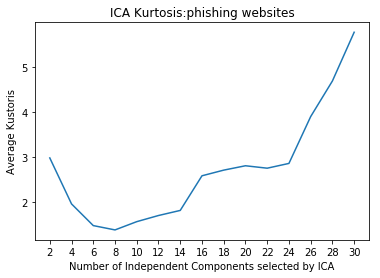

In [438]:
plt.figure()

plt.plot(nb_components, kurto)
plt.xticks(nb_components)
plt.xlabel('Number of Independent Components selected by ICA')
plt.ylabel('Average Kustoris')
plt.title('ICA Kurtosis:' + dataset)

### RCA: random component analysis (Randomized projection)

In [468]:

''' In statistics and in probability theory, distance correlation or distance covariance 
is a measure of dependence between two paired random vectors of arbitrary, not necessarily equal, dimension. 
The population distance correlation coefficient is zero if and only if the random vectors are independent.
Thus, distance correlation measures both linear and nonlinear association between two random variables or random vectors. 
This is in contrast to Pearson's correlation, which can only detect linear association between two random variables. 
'''


def distanceCovariance(X1,X2):

    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def randomized_projection(X,y,k):
    nb_components = list(np.arange(2,(X.shape[1]),2))
    a = [np.zeros(len(nb_components)) for i in range(k)] #We will test k random restarts
    mean=[]
    student=[]
    X_rp=[[]for i in range(k)]
    K = [np.random.RandomState(42) for i in range(k)]
    #print(K)
    for i in range(k):
        for j in range(len(nb_components)):
            rp = SparseRandomProjection(n_components=nb_components[j], random_state=i)
            X1=rp.fit_transform(X)
            X_rp[i].append(X1)           
            a[i][j]=distanceCovariance(X1,X)
        #print(X_rp[i])    
    a = pd.DataFrame(a).T
    student = a.std(axis=1).tolist()
    mean = a.mean(axis=1).tolist()
    
    return (mean, student, nb_components, X_rp, a)
    

In [469]:
mean_rp, student_rp, nb_components_rp, X_rp, a = randomized_projection(X,y,5)

In [474]:
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

accuracy = [[] for i in range(len(X_rp))]

unit = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=1)

for i in range(len(X_rp)):
    for j in range (len(X_rp[i])):
        X_train, X_test, y_train, y_test = train_test_split(X_rp[i][j],y, test_size=0.30)
        clf_boosted = AdaBoostClassifier(base_estimator=unit, random_state=7)
        clf_boosted.fit(X_train, y_train)
        y_pred = clf_boosted.predict(X_test)
        accuracy[i].append(accuracy_score(y_test, y_pred))


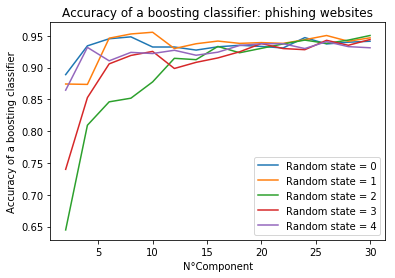

In [473]:
#print(accuracy)
plt.figure()
for i in range(len(accuracy)):
    plt.plot(nb_components_rp, accuracy[i], label='Random state = '+str(i))
plt.ylabel('Accuracy of a boosting classifier')
plt.xlabel('N°Component')
plt.title('Accuracy of a boosting classifier: ' + dataset)
plt.legend(loc="best")

[0.5149933564815472, 0.5788314484586345, 0.6607524412831973, 0.790049089326599, 0.8150628335805479, 0.7796513340244724, 0.7935790544996918, 0.8283603004385203, 0.8234735909901149, 0.8315092665706032, 0.8610598087783348, 0.8748468186928973, 0.8739893866888924, 0.8876950624693831, 0.8938432629412141]


Text(0.5, 1.0, 'Student Reconstruction Correlation: phishing websites')

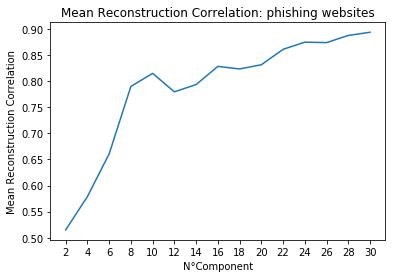

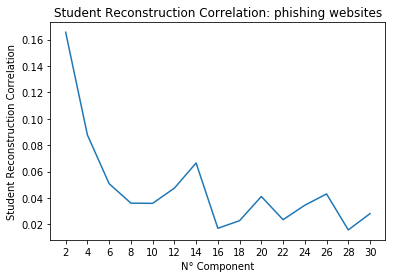

In [472]:
print(mean_rp)
plt.figure()

plt.plot(nb_components_rp, mean_rp)
plt.xticks(nb_components_rp)
plt.ylabel('Mean Reconstruction Correlation')
plt.xlabel('N°Component')
plt.title('Mean Reconstruction Correlation: ' + dataset)

plt.figure()
plt.plot(nb_components_rp, student_rp)
plt.xticks(nb_components_rp)
plt.ylabel('Student Reconstruction Correlation')
plt.xlabel('N° Component')
plt.title('Student Reconstruction Correlation: ' + dataset)


### Random forest classifier
Random trees, and consequently random forest have the particularity to create a hierarchical order of importance among the different features

In [765]:
def random_forest_classifier(X,y): 
    index_features=np.arange(0,31).tolist()
    random_forest= RandomForestClassifier(n_estimators=100, max_depth=5) 
    random_forest.fit(X,y)
    features = random_forest.feature_importances_
    a=[index_features,features.tolist()]
    features = pd.DataFrame(a , index=['index','feature_importance'])    
    features=features.T
    features1  = features.sort_values('feature_importance')
    index = features1.index.tolist()
    feature_importance= features1.feature_importance.tolist()
    #print(index, feature_importance)
    sum = 0
    i=30
    while sum<0.9: #we want to keep 90% of the "information" 
        sum += feature_importance[i]
        i-=1
    top_importance= feature_importance[i:30]
    top_columns= index[i:30]

            
        
    return index ,feature_importance, features.feature_importance.tolist(), top_columns, top_importance


In [766]:
index, ordered_feature_importance, feature_importance,top_columns, top_importance = random_forest_classifier(X,y)

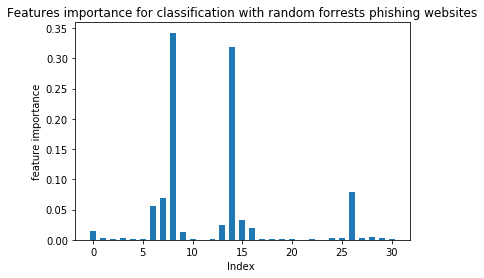

In [773]:
a =np.arange(0,31).tolist()
plt.figure()
plt.bar(a, feature_importance,0.6)
plt.ylabel('feature importance')
plt.xlabel('Index ')
plt.title('Features importance for classification with random forrests ' + dataset)
plt.show()

In [768]:
print(len(top_columns)) # we remove 4 columns

7


## Part 3 : Let's apply the dimensionality reduction algorithms above to our dataset for clustering

In [774]:
X_pca = PCA(0.9).fit_transform(X)
X_ica= FastICA(n_components=16).fit_transform(X)
X_rp = SparseRandomProjection(n_components=10).fit_transform(X)

top_col = dataset_values.columns[top_columns].values
X_rfc = dataset_values[top_col]    
X_rfc = X_rfc.values 
X_rfc=preprocessing.scale(X_rfc)
print(X.shape, X_pca.shape, X_ica.shape, X_rp.shape, X_rfc.shape)

#rfc_phish = np.array(rfc_phish.values,dtype='int64')

(11055, 31) (11055, 20) (11055, 16) (11055, 10) (11055, 7)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


### K-means PCA

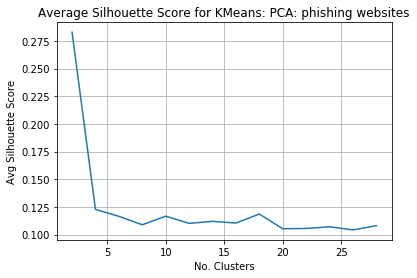

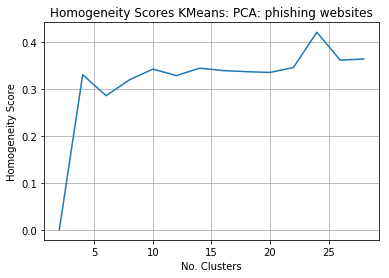

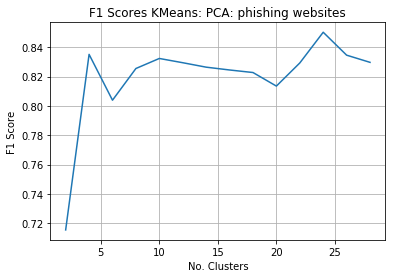

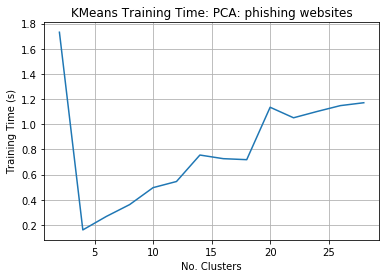

In [433]:
kclusters, sil_scores, f1_scores, homo_scores, train_times, cluster_labels_pca_km =k_means(X_pca,y)
plot_curve_k_means(kclusters, sil_scores, f1_scores, homo_scores, train_times, ': PCA')

### K-means ICA

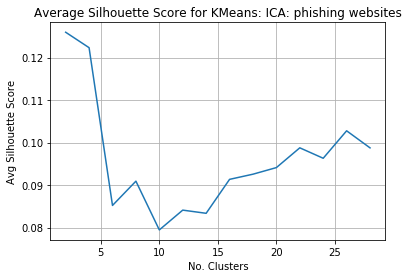

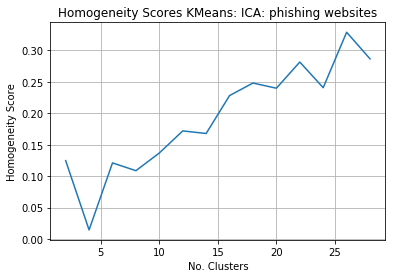

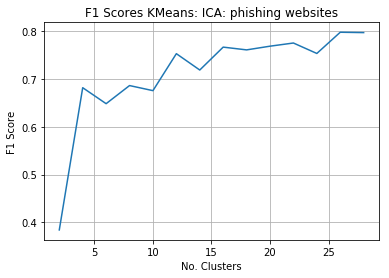

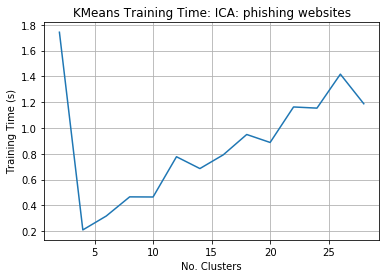

In [440]:
kclusters, sil_scores, f1_scores, homo_scores, train_times, cluster_labels_ica_km=k_means(X_ica,y)
plot_curve_k_means(kclusters, sil_scores, f1_scores, homo_scores, train_times,': ICA')

### K-means RP

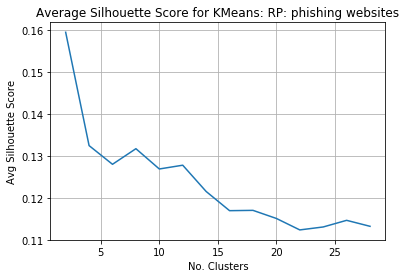

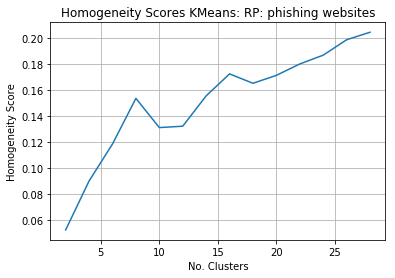

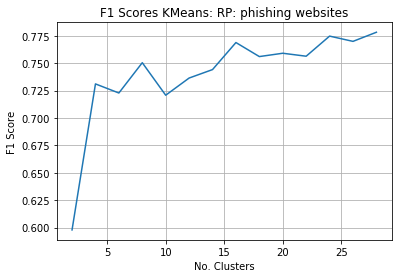

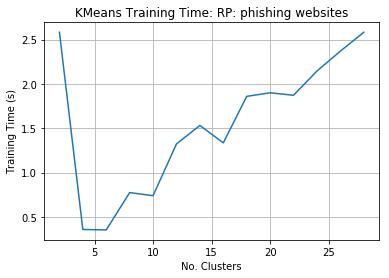

In [476]:
kclusters, sil_scores, f1_scores, homo_scores, train_times, cluster_labels_rp_km=k_means(X_rp,y)
plot_curve_k_means(kclusters, sil_scores, f1_scores, homo_scores, train_times,': RP')

### K-means RFC

In [775]:
kclusters, sil_scores, f1_scores, homo_scores, train_times, cluster_labels_rfc_km=k_means(X_rfc,y)

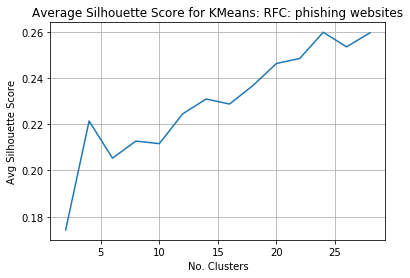

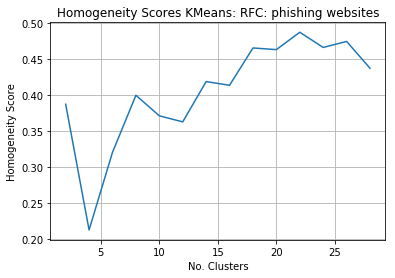

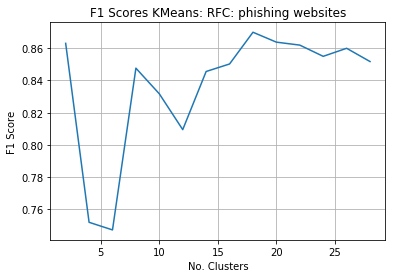

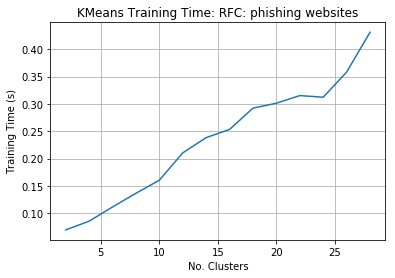

In [776]:
plot_curve_k_means(kclusters, sil_scores, f1_scores, homo_scores, train_times,': RFC')

## EM

### EM PCA

In [ ]:
sil_scores,f1_scores, homo_scores, train_times, aic_scores, bic_scores,cluster_labels_pca_em=EM(X_pca,y)

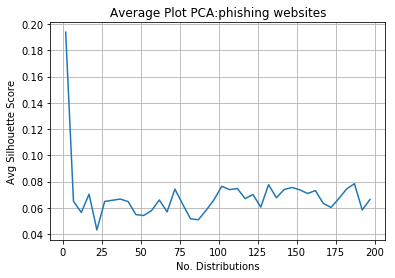

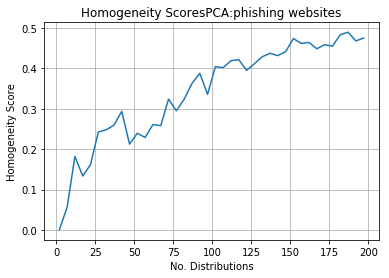

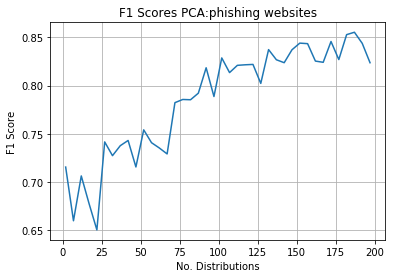

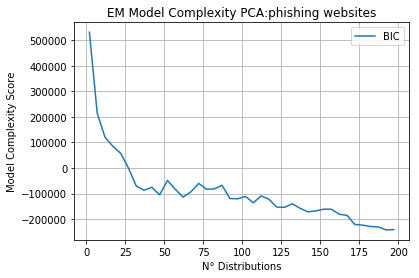

In [435]:
plot_curves_EM(sil_scores,f1_scores, homo_scores, train_times, aic_scores, bic_scores,'PCA')


### EM ICA

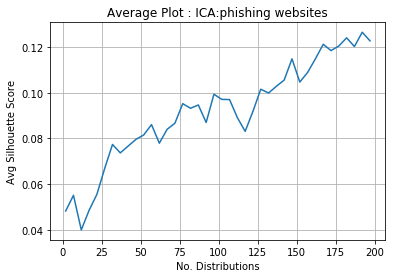

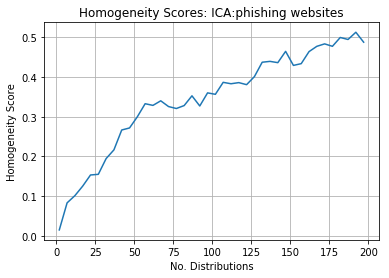

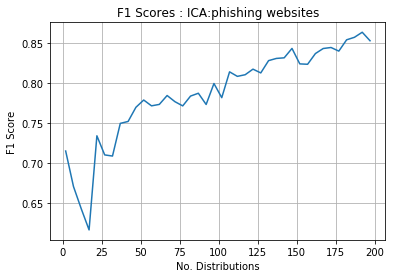

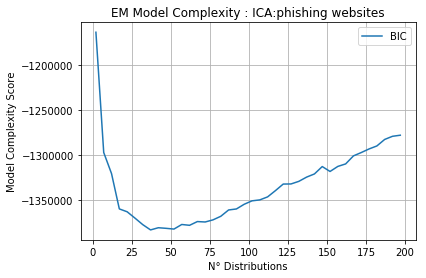

In [777]:
em_ica=EM(X_ica,y)
sil_scores=em_ica[0]
f1_scores=em_ica[1]
homo_scores=em_ica[2]
train_times=em_ica[3]
aic_scores=em_ica[4]
bic_scores=em_ica[5]
plot_curves_EM(sil_scores,f1_scores, homo_scores, train_times, aic_scores, bic_scores,': ICA')

### EM RP

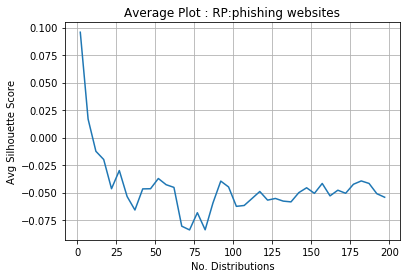

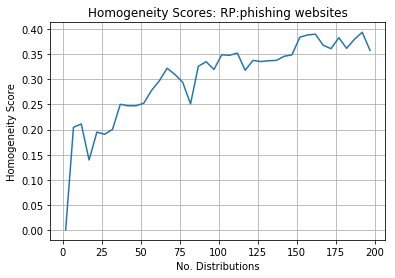

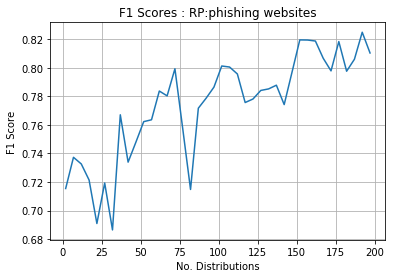

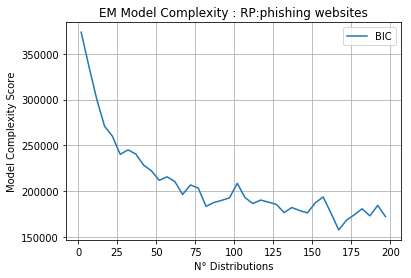

In [477]:
em_rp=EM(X_rp,y)
sil_scores=em_rp[0]
f1_scores=em_rp[1]
homo_scores=em_rp[2]
train_times=em_rp[3]
aic_scores=em_rp[4]
bic_scores=em_rp[5]
plot_curves_EM(sil_scores,f1_scores, homo_scores, train_times, aic_scores, bic_scores,': RP')

### EM RFC

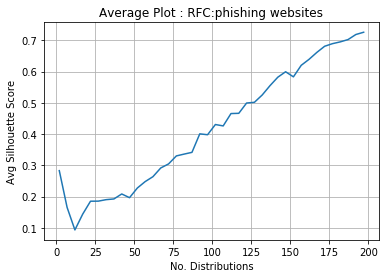

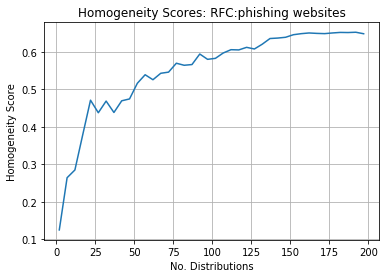

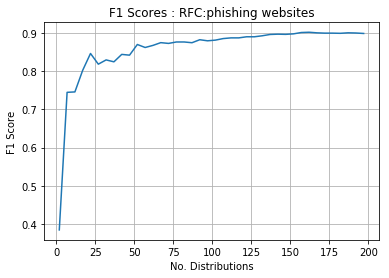

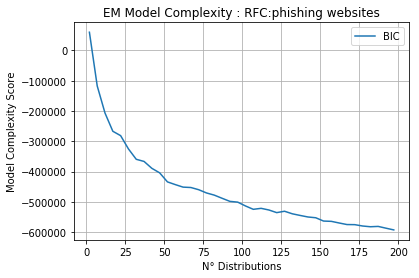

In [778]:
em_rfc=EM(X_rfc,y)
sil_scores=em_rfc[0]
f1_scores=em_rfc[1]
homo_scores=em_rfc[2]
train_times=em_rfc[3]
aic_scores=em_rfc[4]
bic_scores=em_rfc[5]

plot_curves_EM(sil_scores,f1_scores, homo_scores, train_times, aic_scores, bic_scores,': RFC')

### Neural Network
We keep the optimal configuration found for the first assignment

In [652]:
#Source of plot_confusion_matrix : 
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def evaluate_performances(classifier, X_train, X_test, y_train, y_test):
    #training time
    t0=time.time()
    classifier.fit(X_train,y_train)
    training_time=time.time()-t0
    
    #Query time
    t0=time.time()
    classifier.predict(X_test)
    query_time=time.time()-t0
    
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    f1 = f1_score(y_test,y_pred)
    
    print("F1 score:"+str(f1))
    print("accuracy"+str(accuracy))
    print("training time"+ str(training_time))
    print("query time"+ str(query_time))
    plot_confusion_matrix(y_test, y_pred, classes=["-1","1"],
                      title='Confusion matrix')
    

def evaluate_performances1(classifier, X_train, X_test, y_train, y_test):
    #training time
    t0=time.time()
    classifier.fit(X_train,y_train)
    training_time=time.time()-t0
    
    #Query time
    t0=time.time()
    classifier.predict(X_test)
    query_time=time.time()-t0
    
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    f1 = f1_score(y_test,y_pred)
    return(f1, accuracy, query_time, training_time)
    

(7738, 31)
F1 score:0.9679158802911836
accuracy0.964124208622249
training time2.117337465286255
query time0.002991914749145508
Confusion matrix, without normalization
[[1403   55]
 [  64 1795]]


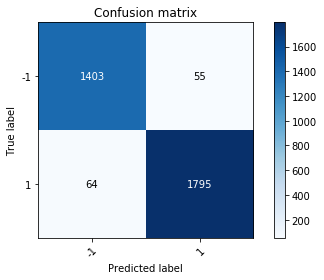

In [484]:
# Original, full dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30)
print(X_train.shape)
NN = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1, random_state=13)
evaluate_performances(NN,X_train, X_test, y_train, y_test)

### Training after PCA

(7738, 16)
F1 score:0.9632453035665669
accuracy0.9593005728067531
training time1.8360912799835205
query time0.002991199493408203
Confusion matrix, without normalization
[[1413   55]
 [  80 1769]]


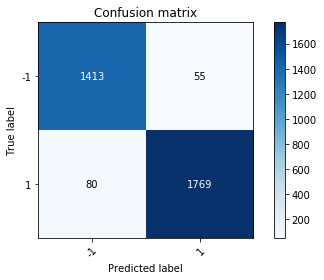

In [550]:
# PCA
X_pca = PCA(n_components=16).fit_transform(X)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca,y, test_size=0.30)
print(X_train_pca.shape)
NN_pca = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1, random_state=13)
evaluate_performances(NN_pca,X_train_pca, X_test_pca, y_train, y_test)


In [724]:
f1_pca1=[]
accuracy_pca1=[] 
query_time_pca1=[]
train_time_pca1=[]
for i in range(2,5,2):
    X_pca = PCA(n_components=i).fit_transform(X)
    print(X_pca.shape)
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca,y, test_size=0.30)
    NN_pca = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1)
    f1, accuracy, query_time, train_time = evaluate_performances1(NN_pca,X_train_pca, X_test_pca, y_train, y_test)
    f1_pca1.append(f1)
    accuracy_pca1.append(accuracy)
    query_time_pca1.append(query_time)
    train_time_pca1.append(train_time)

(11055, 2)
(11055, 4)


In [730]:
print(accuracy_pca1)
i=1
f1_pca[i]=f1_pca1[i]
accuracy_pca[i]= accuracy_pca1[i]
query_time_pca[i]=query_time_pca1[i]
train_time_pca[i]=train_time_pca1[i]

print(f1_pca)

[0.6424479951763642, 0.8592101296352126]
[0.7070158102766798, 0.874496103198065, 0.9222595078299776, 0.9390276658608648, 0.9426573426573427, 0.9489247311827956, 0.9569716775599129, 0.9605122732123799, 0.9624628679449095, 0.9661472326706072, 0.96290365625834, 0.962451684152402, 0.9490373725934315, 0.9687082107515378, 0.9627630868861307]


### Training after ICA

(7738, 16)
F1 score:0.9207253886010364
accuracy0.9077479650286403
training time0.7749290466308594
query time0.0019958019256591797
Confusion matrix, without normalization
[[1234  260]
 [  46 1777]]


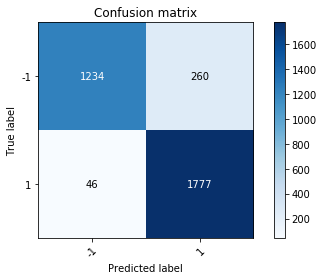

In [731]:
# ICA
X_ica= FastICA(n_components=16).fit_transform(X)

X_train_ica, X_test_ica, y_train, y_test = train_test_split(X_ica,y, test_size=0.30)
print(X_train_ica.shape)
NN_ica = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1, random_state=13)
evaluate_performances(NN_ica,X_train_ica, X_test_ica, y_train, y_test)


In [676]:
f1_ica=[]
accuracy_ica=[] 
query_time_ica=[]
train_time_ica=[]

for i in range(2,31,2):
    X_ica = FastICA(n_components=i).fit_transform(X)
    print(X_ica.shape)
    X_train_ica, X_test_ica, y_train, y_test = train_test_split(X_ica,y, test_size=0.30)
    NN_ica = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1)
    f1, accuracy, query_time, train_time = evaluate_performances1(NN_ica,X_train_ica, X_test_ica, y_train, y_test)
    f1_ica.append(f1)
    accuracy_ica.append(accuracy)
    query_time_ica.append(query_time)
    train_time_ica.append(train_time)

(11055, 2)
(11055, 4)
(11055, 6)
(11055, 8)
(11055, 10)
(11055, 12)
(11055, 14)
(11055, 16)
(11055, 18)
(11055, 20)
(11055, 22)
(11055, 24)
(11055, 26)
(11055, 28)
(11055, 30)


In [705]:
f1_ica=f1_ica_1
accuracy_ica=acc_ica
query_time_ica=query_time_ica_1
train_time_ica=train_time_ica_1

a= [f1_ica,accuracy_ica, query_time_ica, train_time_ica]
print(f1_ica, train_time_ica)

[0.7065704815753558, 0.8706199460916442, 0.9282765737874097, 0.9185185185185185, 0.928395061728395, 0.9285136228756407, 0.9365641165260006, 0.9437206878582595, 0.9283621837549932, 0.9453376205787781, 0.9486389316897791, 0.9417576703068123, 0.9546044098573282, 0.9531590413943356, 0.9477389656106148] [0.46774888038635254, 0.8616945743560791, 0.8457400798797607, 0.433840274810791, 0.8946080207824707, 0.9238049983978271, 1.5089654922485352, 1.7373545169830322, 0.644277811050415, 1.0362272262573242, 1.3015556335449219, 1.4421117305755615, 1.9517810344696045, 1.117013931274414, 1.7682712078094482]


### Training after RP

(7738, 10)
F1 score:0.8916055419722901
accuracy0.8797105818510702
training time1.7732596397399902
query time0.001995086669921875
Confusion matrix, without normalization
[[1277  167]
 [ 232 1641]]
(7738, 22)
F1 score:0.9401939655172414
accuracy0.933072053059994
training time1.664548397064209
query time0.0029921531677246094
Confusion matrix, without normalization
[[1350  144]
 [  78 1745]]


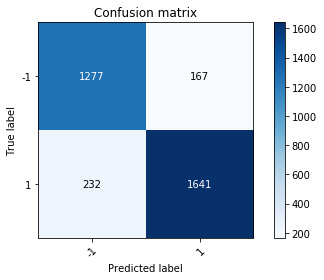

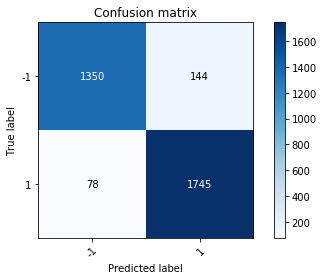

In [498]:
# RP
X_rp = SparseRandomProjection(n_components=10).fit_transform(X)
X_train_rp, X_test_rp, y_train, y_test = train_test_split(X_rp,y, test_size=0.30)
print(X_train_rp.shape)
NN_rp = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1, random_state=13)
evaluate_performances(NN_rp,X_train_rp, X_test_rp, y_train, y_test)


X_rp = SparseRandomProjection(n_components=22).fit_transform(X)
X_train_rp, X_test_rp, y_train, y_test = train_test_split(X_rp,y, test_size=0.30)
print(X_train_rp.shape)
NN_rp = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1, random_state=13)
evaluate_performances(NN_rp,X_train_rp, X_test_rp, y_train, y_test)

In [739]:
f1_rp=[]
accuracy_rp=[] 
query_time_rp=[]
train_time_rp=[]

for i in range(2,31,2):
    X_rp = SparseRandomProjection(n_components=i).fit_transform(X)
    print(X_rp.shape)
    X_train_rp, X_test_rp, y_train, y_test = train_test_split(X_rp,y, test_size=0.30)
    NN_rp = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1)
    f1, accuracy, query_time, train_time = evaluate_performances1(NN_rp,X_train_rp, X_test_rp, y_train, y_test)
    f1_rp.append(f1)
    accuracy_rp.append(accuracy)
    query_time_rp.append(query_time)
    train_time_rp.append(train_time)

(11055, 2)
(11055, 4)
(11055, 6)
(11055, 8)
(11055, 10)
(11055, 12)
(11055, 14)
(11055, 16)
(11055, 18)
(11055, 20)
(11055, 22)
(11055, 24)
(11055, 26)
(11055, 28)
(11055, 30)


In [805]:
print(accuracy_rp)


[0.7497738920711486, 0.7425384383479048, 0.8610189930660235, 0.7648477539945734, 0.8803135363280072, 0.9086523967440459, 0.9158878504672897, 0.9394030750678324, 0.9538739825143202, 0.9523665963219777, 0.9472414832680133, 0.9517636418450407, 0.9496533011757612, 0.9535725052758517, 0.9632197769068436]


### Training after RFC

(7738, 25)
F1 score:0.817391304347826
accuracy0.7657521857099789
training time1.3254551887512207
query time0.0030045509338378906
Confusion matrix, without normalization
[[ 801  660]
 [ 117 1739]]


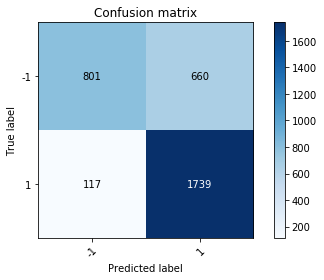

In [499]:
# RFC
X_train_rfc, X_test_rfc, y_train, y_test = train_test_split(X_rfc,y, test_size=0.30)
print(X_train_rfc.shape)
NN_rfc = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1, random_state=12)
evaluate_performances(NN_rfc,X_train_rfc, X_test_rfc, y_train, y_test)

In [788]:
f1_rfc=[]
accuracy_rfc=[] 
query_time_rfc=[]
train_time_rfc=[]

for i in range(2,31,2):
    top_columns=index[30-i+1:]
    top_col = dataset_values.columns[top_columns].values
    X_rfc = dataset_values[top_col]    
    X_rfc = X_rfc.values 
    X_rfc=preprocessing.scale(X_rfc)
    print(X_rfc.shape)
    X_train_rfc, X_test_rfc, y_train, y_test = train_test_split(X_rfc,y, test_size=0.30)
    NN_rfc = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1)
    f1, accuracy, query_time, train_time = evaluate_performances1(NN_rfc,X_train_rfc, X_test_rfc, y_train, y_test)
    f1_rfc.append(f1)
    accuracy_rfc.append(accuracy)
    query_time_rfc.append(query_time)
    train_time_rfc.append(train_time)

C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 2)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 4)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 6)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 8)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 10)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 12)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 14)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 16)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 18)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 20)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 22)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 24)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 26)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 28)


C:\Users\Gwénolé\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(11055, 30)


### Comparaison of the F1 score and Training Time

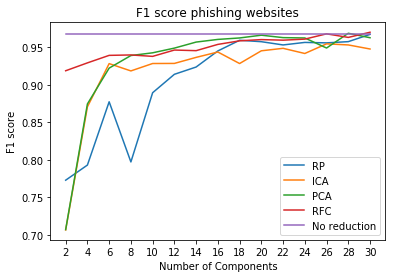

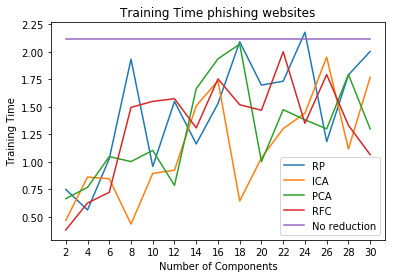

In [813]:
n_comp = np.arange(2,31,2).tolist()

f1_not_reduced = [0.9679158802911836 for i in range(len(f1_rp))]
plt.figure()
plt.plot(n_comp, f1_rp, label="RP")
plt.plot(n_comp, f1_ica, label="ICA")
plt.plot(n_comp, f1_pca, label="PCA")
plt.plot(n_comp, f1_rfc, label="RFC")
plt.plot(n_comp, f1_not_reduced, label="No reduction")
                  
plt.xticks(n_comp)
plt.xlabel('Number of Components')
plt.ylabel('F1 score')
plt.title('F1 score ' + dataset)
plt.legend(loc="best")



train_time_not_reduced = [2.117337465286255 for i in range(len(f1_rp))]
plt.figure()
plt.plot(n_comp, train_time_rp, label="RP")
plt.plot(n_comp, train_time_ica, label="ICA")
plt.plot(n_comp, train_time_pca, label="PCA")
plt.plot(n_comp, train_time_rfc, label="RFC")
plt.plot(n_comp, train_time_not_reduced, label="No reduction")
                  
plt.xticks(n_comp)
plt.xlabel('Number of Components')
plt.ylabel('Training Time')
plt.title('Training Time ' + dataset)
plt.legend(loc="best")






## Part 5: Training using clustering as dimensionality reduction

In [ ]:
km = KMeans(n_clusters=4,n_init=10,random_state=100).fit(phishX)
km_labels = km.labels_
em = EM(n_components=28,covariance_type='full',n_init=1,warm_start=True,random_state=100).fit(phishX)
em_labels = em.predict(phishX)

clust_full = addclusters(phishX,km_labels,em_labels)
clust_pca = addclusters(pca_phish,km_labels,em_labels)
clust_ica = addclusters(ica_phish,km_labels,em_labels)
clust_rca = addclusters(rca_phish,km_labels,em_labels)
clust_rfc = addclusters(rfc_phish,km_labels,em_labels)

In [970]:
def k_means_1(X, y, k):
    kmeans = KMeans(n_clusters=k,random_state=100,n_jobs=-1).fit(X)
    labels = kmeans.labels_
    X_cluster = [np.zeros(k) for i in range(len(X))]
    for i in range(len(X_cluster)):  #one hot encoding of the cluster for each given point
        X_cluster[i][labels[i]]=1
        X_cluster[i]=X_cluster[i].tolist()
    return X_cluster

def em_1(X,y,k):
    em = GaussianMixture(n_components=k,covariance_type='full',n_init=1,warm_start=True,random_state=100).fit(X)
    labels = em.predict(X)
    X_cluster = [np.zeros(k) for i in range(len(X))]
    for i in range(len(X_cluster)):
        X_cluster[i][labels[i]]=1
        X_cluster[i]=X_cluster[i].tolist()
    return X_cluster


def em_km(X,y,k):
    
    
    kmeans = KMeans(n_clusters=k,random_state=100,n_jobs=-1).fit(X)
    labels_km = kmeans.labels_
    em = GaussianMixture(n_components=k,covariance_type='full',n_init=1,warm_start=True,random_state=100).fit(X)
    labels_em = em.predict(X)
    X_cluster = [np.zeros(2*k) for i in range(len(X))]
    for i in range(len(X_cluster)):
        X_cluster[i][labels_km[i]]=1
        X_cluster[i][labels_em[i]+k]=1
        X_cluster[i]=X_cluster[i].tolist()
    return X_cluster
        
#X_cluster_km = k_means_1(X,y,16) 
#X_cluster_em = em_1(X,y, 50)
    
    
def em_km1(X,y,k):
    
    
    kmeans = KMeans(n_clusters=k,random_state=100,n_jobs=-1).fit(X)
    labels_km = kmeans.labels_
    em = GaussianMixture(n_components=k,covariance_type='full',n_init=1,warm_start=True,random_state=100).fit(X)
    labels_em = em.predict(X)
    X_cluster = [np.zeros(2) for i in range(len(X))]
    for i in range(len(X_cluster)):
        X_cluster[i][0]=labels_km[i]
        X_cluster[i][1]=labels_em[i]
        X_cluster[i]=X_cluster[i].tolist()
    return X_cluster
  
def k_means_2(X, y, k):
    kmeans = KMeans(n_clusters=k,random_state=100,n_jobs=-1).fit(X)
    labels = kmeans.labels_
    X_cluster = [[0] for i in range(len(X))]
    for i in range(len(X_cluster)):  #one hot encoding of the cluster for each given point
        X_cluster[i][0]=labels[i]
    return X_cluster


In [ ]:
X_km = k_means_1(X, y, 4)
X_km_pca = k_means_1(X_pca, y, 4)
X_km_ica = k_means_1(X_ica, y, 4)
X_km_rp = k_means_1(X_rp, y, 4)
X_km_rfc = k_means_1(X_rfc, y, 4)


X_em = em_1(X,y,28)
X_em_pca = em_1(X_pca, y, 28)
X_em_ica = em_1(X_ica, y, 28)
X_em_rp = em_1(X_rp, y, 28)
X_em_rfc = em_1(X_rfc, y, 28)

### K-means

In [855]:
f1_km=[]
accuracy_km=[] 
query_time_km=[]
train_time_km=[]


for i in range(2,50):
    X_cluster_km = k_means_1(X,y,i)
    X_train_cluster_km, X_test_cluster_km, y_train, y_test = train_test_split(X_cluster_km,y, test_size=0.30)
    NN_cluster_km = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1, random_state=13)
    f1, accuracy, query_time, train_time = evaluate_performances1(NN_cluster_km,X_train_cluster_km, X_test_cluster_km, y_train, y_test)
    f1_km.append(f1)
    accuracy_km.append(accuracy)
    query_time_km.append(query_time)
    train_time_km.append(train_time)
    



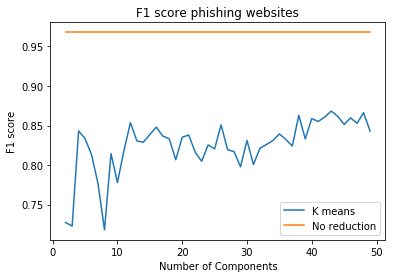

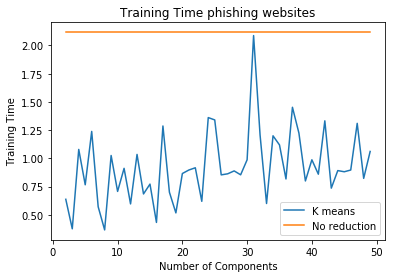

In [908]:
n_comp = np.arange(2,50,1).tolist()

f1_not_reduced = [0.9679158802911836 for i in range(len(f1_km))]
plt.figure()
plt.plot(n_comp, f1_km, label="K means")
plt.plot(n_comp, f1_not_reduced, label="No reduction")             
plt.xlabel('Number of Components')
plt.ylabel('F1 score')
plt.title('F1 score ' + dataset)
plt.legend(loc="best")



train_time_not_reduced = [2.117337465286255 for i in range(len(f1_km))]
plt.figure()
plt.plot(n_comp, train_time_km, label="K means")
plt.plot(n_comp, train_time_not_reduced, label="No reduction")
plt.xlabel('Number of Components')
plt.ylabel('Training Time')
plt.title('Training Time ' + dataset)
plt.legend(loc="best")



### EM

In [911]:
f1_em=[]
accuracy_em=[] 
query_time_em=[]
train_time_em=[]

for i in range(2,50):
    X_cluster_em = em_1(X,y, i)

    X_train_cluster_em, X_test_cluster_em, y_train, y_test = train_test_split(X_cluster_em,y, test_size=0.30)
    NN_cluster_em = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1, random_state=5)
    #evaluate_performances(NN_cluster_em,X_train_cluster_em, X_test_cluster_em, y_train, y_test)

    f1, accuracy, query_time, train_time = evaluate_performances1(NN_cluster_em,X_train_cluster_em, X_test_cluster_em, y_train, y_test)
    f1_em.append(f1)
    accuracy_em.append(accuracy)
    query_time_em.append(query_time)
    train_time_em.append(train_time)
    




### EM + KM

In [932]:
f1_em_km=[]
accuracy_em_km=[] 
query_time_em_km=[]
train_time_em_km=[]

for i in range(2,50, 2):
    X_cluster_em_km = em_km(X,y, i)
    X_train_cluster_em, X_test_cluster_em, y_train, y_test = train_test_split(X_cluster_em_km,y, test_size=0.30)
    NN_cluster_em_km = MLPClassifier(hidden_layer_sizes=(60,1), solver='adam', activation='relu', learning_rate_init=0.1)
    f1, accuracy, query_time, train_time = evaluate_performances1(NN_cluster_em_km,X_train_cluster_em, X_test_cluster_em, y_train, y_test)
    f1_em_km.append(f1)
    accuracy_em_km.append(accuracy)
    query_time_em_km.append(query_time)
    train_time_em_km.append(train_time)
    

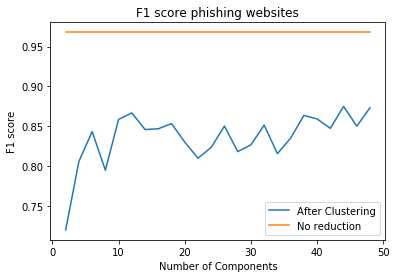

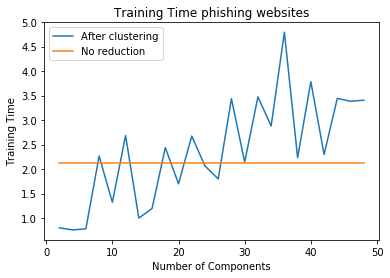

In [960]:
n_comp = np.arange(2,50,2).tolist()

f1_not_reduced = [0.9679158802911836 for i in range(len(f1_em_km))]
plt.figure()
plt.plot(n_comp, f1_em_km, label="After Clustering")
plt.plot(n_comp, f1_not_reduced, label="No reduction")             
plt.xlabel('Number of Components')
plt.ylabel('F1 score')
plt.title('F1 score ' + dataset)
plt.legend(loc="best")



train_time_not_reduced = [2.117337465286255 for i in range(len(f1_em_km))]
plt.figure()
plt.plot(n_comp, train_time_em_km, label="After clustering")
plt.plot(n_comp, train_time_not_reduced, label="No reduction")
plt.xlabel('Number of Components')
plt.ylabel('Training Time')
plt.title('Training Time ' + dataset)
plt.legend(loc="best")
